<a href="https://www.kaggle.com/code/saswatamukherjee/paper-structure-guided-lane-detection?scriptVersionId=95801139" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  **STRUCTURE GUIDED LANE DETECTION**

[Github Link](https://github.com/Saswata13/PAPER---STRUCTURE-GUIDED-LANE-DETECTION)

## GROUP MEMBERS:
* Saswata Mukherjee: 2019A4PS0162G
* Suhaas Mahajan:    2019AAPS0315G
* Arnav Jain:        2019A7PS0158G

The paper we are trying to implement is based on structure-guided lane detection for autonomous vehicles. The original datasets used by the authors are the **CU Lane** and the **TuSimple** datasets. Both these datasets are very big and computationally expensive to work on. For our purposes we will be using the **KITTI Road dataset** published by Karlsruhe Institute of Technology. The link to the original dataset is: http://www.cvlibs.net/datasets/kitti/eval_road.php

We have used a smaller version of this dataset from the link: https://www.kaggle.com/datasets/sumanyughoshal/kitti-road-dataset.

In [1]:
import os
import math
import glob
import re
import torch.nn as nn
from torch.autograd import Variable
import torch
import cv2
import json
import random
import numpy as np
from skimage import io, transform
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image as im

 **'args'** is a dictionary that specifies the hyperparameters of our framework and path to the directories from which input is fed. 

In [2]:
args={
      #Path to the output directory
     "output_dir": "./output",
    
      #Path to the root directory
     "root_dir": "../input/kitti-road-dataset/data_road",
      
      #Path to the training directory
     'train_dir': '../input/kitti-road-dataset/data_road/training',
     # 'holdout_path': './',
      
      #The model of the framework implemented
     "model2": "ResNetM2",
       
     "batch_size": 32 ,
      
      #Learning Rate
     "lr": 0.0005 ,
      
      #Number of classes: Lane and Not Lane
     "num_classes": 2,
     
     'attention': 1,
     'skip_conn': 1 ,
     'decoder_type': 'convTr',
    
      #Enable to the encoder block
     'enc-bn-enable': 1,
    
      #Enable to the decoder block
     'dec-bn-enable': 1,
     
     'epochs': 100,
#      'gamma': 0.9,
     'alpha': 0.3,
     'patience': 5,
     'milestones': 2,
     'num_workers':2}

## DETAILS ABOUT THE DATASET:

The KITTI Road dataset that we are using consists of 289 training images and 290 test images. It contains three different categories of road scenes:
   * uu - urban unmarked (98 training/100 test)
   * um - urban marked (95 training/96 test)
   * umm - urban multiple marked lanes (96 training/94 test)
   
The 289 training examples are accompanied by their labels in the form of ground truth masks. The 290 test examples however, come without labels. In the following section, we would be answering a few questions regarding the dataset.

## Midsem Summary

### Q1. Is the dataset balanced?

The dataset is fairly well balanced for an urban scenario. As mentioned above, there are almost a hundred different examples of each of the three types of lanes: unmarked, marked and multiple marked. One example from each of the three scanarios have been displayed below


### Q2. Why is the dataset relevant to our chosen paper?
​
The paper chosen by us tries to address three main difficulties of the lane detection task. These difficulties are:
* Characterizing lanes based on different methods of annotations.
* Identification and modelling of relationship between surrounding scene and lanes.
* Supporting more attributes of the scene to come up with better results while detecting lanes.

The paper proposes a novel structure guided framework, **SGNet** to address the above mentioned difficulties. A new lane representation is introduced and a top-down vanishing point guided mechanism is proposed. Hence our chosen dataset is relevant to the paper because:
* This dataset characterizes lanes differently as compared to the CULane and TuSimple datasets. The CULane and TuSimple datasets annotate lane boundaries based on the co-ordinates of the lane markings. This dataset, however, follows a segmentation based annotation approach in which not only the lane boundaries, but the entire lane is shown as a separate entity from other entities of a constituent scene. Hence it uses a different approach for annotation.
* For identification and modelling of the relationship between surrounding scenes and lanes, it is desired for the scenes around the lanes to be very diverse. Our chosen dataset satisfies this condition too as it depicts a variety of urban scenarios and structures surrounding the lanes.
* For supporting more attributes of the scene to come up with a better lane segmentation, it is important for a large number of attributes to be present in the data. The field of view of our chosen dataset is large enough and has captured various attributes like surrounding vehicles, buildings, walls and other obstructions

### Q3. What are the limitations of this dataset?

The major limitation of this dataset is its size. With less than 300 number of training images, it is very hard to make a model generalize well based on this data. Besides this, the majority of the data consists of images taken during the daytime. It should also be noted that the dataset consists of picture from an urban scenario only, a rural scenario may or may not be a different story depending on some specific cases.

 

# OVERCOMING THE LIMITATIONS

To overcome working with only 289 training examples, we have used a library, *Automold*, which has been made specifically for this purpose. The link to the Automold library is: https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library

We have used functions from Automold to introduce special augmentations like the introduction of fog, snow, shadows, which are specific to the region and time of a particular scenario. Regular augmentation effects like blurring, brightening, darkening of scenes have also been kept. As a result, our training data has expanded to *1734* examples.

In [3]:
#Using seed for ensuring reprobucibilty 
np.random.seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Function for normalization
def normalize(img, mean, std):
    img = img/255.0
    img[0] = (img[0] - mean[0]) / std[0]
    img[1] = (img[1] - mean[1]) / std[1]
    img[2] = (img[2] - mean[2]) / std[2]
    img = np.clip(img, 0.0, 1.0)

    return img

#Denormalization function
def denormalize(img, mean, std):
    img[0] = (img[0] * std[0]) + mean[0]
    img[1] = (img[1] * std[1]) + mean[1]
    img[2] = (img[2] * std[2]) + mean[2]
    img = img * 255

    img = np.clip(img, 0, 255)
    return img

#To fetch the path of labels
def get_label_paths(label_path):
    label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
                   for path in glob(os.path.join(label_path, '*_road_*.png'))}

    return label_paths

#To obtain the test paths
def get_test_paths(test_path):
    test_paths = [os.path.basename(path)
                      for path in glob(os.path.join(test_path, '*.png'))]

    return test_paths

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

def gen_test_output(n_class, testloader, model, test_folder):
    model.eval();
    with torch.no_grad():
        for i, data in enumerate(testloader):
            sample = data
            images = sample['image']
            images = images.float()
            images = Variable(images.to(device))

            output = model(images)
            output = torch.sigmoid(output)
            output = output.cpu()
            N, c, h, w = output.shape
            pred = np.squeeze(output.detach().cpu().numpy(), axis=0)

            pred = pred.transpose((1, 2, 0))
            pred = pred.argmax(axis=2)
            pred = (pred > 0.5)

            pred = pred.reshape(*pred.shape, 1)
            pred = np.concatenate((pred, np.invert(pred)), axis=2).astype('float')
            pred = np.concatenate((pred, np.zeros((*pred[:,:,0].shape, 1))), axis=2).astype('float')

            pred[pred == 1.0] = 127.0
            # images = images.cpu().detach().numpy()
            # images = np.squeeze(images)
            # images = images.transpose((1, 2, 0))

            # images = denormalize(images, mean=[0.485, 0.456, 0.406],
            #                         std=[0.229, 0.224, 0.225])
            test_paths = get_test_paths(test_folder)
            output = resize_label(os.path.join(test_folder, test_paths[i]), pred)
            output = output/127.0
            output = np.clip(output, 0.0, 1.0)
            yield test_paths[i], output

def save_inference_samples(output_dir, testloader, model, test_folder):
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(2, testloader, model, test_folder)
    for name, image in image_outputs:
        plt.imsave(os.path.join(output_dir, name), image)

def resize_label(image_path, label):
    image = io.imread(image_path)
    label = transform.resize(label, image.shape)
    output = cv2.addWeighted(image, 0.6, label, 0.4, 0, dtype = 0)
    return output

# Trainloader and Testloader skeleton

In [4]:
#from utils import get_label_paths, get_test_paths, normalize

np.random.seed(1234)

#Defining the blueprint of the Train-Loader
class KittiDatasetTrain(Dataset):
    def __init__(self, rootdir, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.traindir = rootdir + "/training/image_2"
        self.labeldir = rootdir + "/training/gt_image_2"

    def __getitem__(self, index):

        label_paths = get_label_paths(label_path=self.labeldir)
        image_path = list(label_paths)[index]
        img = io.imread(os.path.join(self.traindir, image_path))
        label = io.imread(label_paths[image_path])
        background_color = np.array([255, 0, 0])
        img = cv2.resize(img, (256, 256))
        label = cv2.resize(label, (256, 256))
        gt_bg = np.all(label == background_color, axis=2)
        gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
        gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
        img = normalize(img, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

        img = img.transpose((2, 0, 1))
        gt_image = gt_image.transpose((2, 0, 1))
        gt_image = gt_image.astype("float")

        img = torch.from_numpy(img)
        #img = torch.clamp(img, 0, 1)
        sample = {'image': img,
                'label': torch.from_numpy(gt_image)}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        path, dirs, files = next(os.walk(self.traindir))
        n = len(files)
        return n # of how many examples(images?)


#Defining the blueprint of the Test-Loader
class KittiDatasetTest(Dataset):
    def __init__(self, rootdir, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.testdir = rootdir + "/testing/image_2"

    def __getitem__(self, index):

        test_paths = get_test_paths(test_path=self.testdir)
        image_path = test_paths[index]
        img = io.imread(os.path.join(self.testdir, image_path))

        img = cv2.resize(img, (256, 256))
        img = normalize(img, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        img = img.transpose((2, 0, 1))

        img = torch.from_numpy(img)
        #img = torch.clamp(img, 0, 1)
        sample = {'image': img}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        path, dirs, files = next(os.walk(self.testdir))
        n = len(files)
        return n

# DATA AUGMENTATION USING THE AUTOMOLD LIBRARY

In [5]:
# Data Augmentation functions
err_not_np_img= "not a numpy array or list of numpy array" 
err_img_arr_empty="Image array is empty"
err_row_zero="No. of rows can't be <=0"
err_column_zero="No. of columns can't be <=0"
err_invalid_size="Not a valid size tuple (x,y)"
err_caption_array_count="Caption array length doesn't matches the image array length"

def is_numpy_array(x):
    return isinstance(x, np.ndarray)
def is_tuple(x):
    return type(x) is tuple
def is_list(x):
    return type(x) is list
def is_numeric(x):
    return type(x) is int
def is_numeric_list_or_tuple(x):
    for i in x:
        if not is_numeric(i):
            return False
    return True
err_brightness_coeff="brightness coeff can only be between 0.0 to 1.0" 
err_darkness_coeff="darkness coeff can only be between 0.0 to 1.0" 

def change_light(image, coeff):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    image_HLS[:,:,1] = image_HLS[:,:,1]*coeff ## scale pixel values up or down for channel 1(Lightness)
    if(coeff>1):
        image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    else:
        image_HLS[:,:,1][image_HLS[:,:,1]<0]=0
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB 


def verify_image(image):
    if is_numpy_array(image):
        pass
    elif(is_list(image)):
        image_list=image
        for img in image_list:
            if not is_numpy_array(img):
                raise Exception(err_not_np_img)
    else:
        raise Exception(err_not_np_img)

#Function to intensify the lighting of the scene
def brighten(image, brightness_coeff=-1): 
    verify_image(image)
    if(brightness_coeff!=-1):
        if(brightness_coeff<0.0 or brightness_coeff>1.0):
            raise Exception(err_brightness_coeff)
    if(is_list(image)):
        image_RGB=[]
        image_list=image
        for img in image_list:
            if(brightness_coeff==-1):
                brightness_coeff_t=1+ random.uniform(0,1) ## coeff between 1.0 and 1.5
            else:
                brightness_coeff_t=1+ brightness_coeff ## coeff between 1.0 and 2.0
            image_RGB.append(change_light(img,brightness_coeff_t))
    else:
        if(brightness_coeff==-1):
            brightness_coeff_t=1+ random.uniform(0,1) ## coeff between 1.0 and 1.5
        else:
            brightness_coeff_t=1+ brightness_coeff ## coeff between 1.0 and 2.0
        image_RGB= change_light(image,brightness_coeff_t)
    return image_RGB

#Function to decrease the lighting of the scene
def darken(image, darkness_coeff=-1): ##function to darken the image
    verify_image(image)
    if(darkness_coeff!=-1):
        if(darkness_coeff<0.0 or darkness_coeff>1.0):
            raise Exception(err_darkness_coeff) 

    if(is_list(image)):
        image_RGB=[]
        image_list=image
        for img in image_list:
            if(darkness_coeff==-1):
                darkness_coeff_t=1- random.uniform(0,1)
            else:
                darkness_coeff_t=1- darkness_coeff            
            image_RGB.append(change_light(img,darkness_coeff_t))
    else:
        if(darkness_coeff==-1):
             darkness_coeff_t=1- random.uniform(0,1)
        else:
            darkness_coeff_t=1- darkness_coeff  
        image_RGB= change_light(image,darkness_coeff_t)
    return image_RGB

#Function to generate shadows in the scene
def generate_shadow_coordinates(imshape, no_of_shadows, rectangular_roi, shadow_dimension):
    vertices_list=[]
    x1=rectangular_roi[0]
    y1=rectangular_roi[1]
    x2=rectangular_roi[2]
    y2=rectangular_roi[3]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(shadow_dimension): ## Dimensionality of the shadow polygon
            vertex.append((random.randint(x1, x2),random.randint(y1, y2)))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices

def shadow_process(image,no_of_shadows,x1,y1,x2,y2, shadow_dimension):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows,(x1,y1,x2,y2), shadow_dimension) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def add_shadow(image,no_of_shadows=1,rectangular_roi=(-1,-1,-1,-1), shadow_dimension=5):## ROI:(top-left x1,y1, bottom-right x2,y2), shadow_dimension=no. of sides of polygon generated
    verify_image(image)
    if not(is_numeric(no_of_shadows) and no_of_shadows>=1 and no_of_shadows<=10):
        raise Exception(err_shadow_count)
    if not(is_numeric(shadow_dimension) and shadow_dimension>=3 and shadow_dimension<=10):
        raise Exception(err_shadow_dimension)
    if is_tuple(rectangular_roi) and is_numeric_list_or_tuple(rectangular_roi) and len(rectangular_roi)==4:
        x1=rectangular_roi[0]
        y1=rectangular_roi[1]
        x2=rectangular_roi[2]
        y2=rectangular_roi[3]
    else:
        raise Exception(err_invalid_rectangular_roi)
    if rectangular_roi==(-1,-1,-1,-1):
        x1=0
        
        if(is_numpy_array(image)):
            y1=image.shape[0]//2
            x2=image.shape[1]
            y2=image.shape[0]
        else:
            y1=image[0].shape[0]//2
            x2=image[0].shape[1]
            y2=image[0].shape[0]

    elif x1==-1 or y1==-1 or x2==-1 or y2==-1 or x2<=x1 or y2<=y1:
        raise Exception(err_invalid_rectangular_roi)
    if(is_list(image)):
        image_RGB=[]
        image_list=image
        for img in image_list:
            output=shadow_process(img,no_of_shadows,x1,y1,x2,y2, shadow_dimension)
            image_RGB.append(output)
    else:
        output=shadow_process(image,no_of_shadows,x1,y1,x2,y2, shadow_dimension)
        image_RGB = output

    return image_RGB

#Function to add snow in the scene 
err_snow_coeff="Snow coeff can only be between 0 and 1"
def snow_process(image,snow_coeff):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    brightness_coefficient = 2.5 
    imshape = image.shape
    snow_point=snow_coeff ## increase this for more snow
    image_HLS[:,:,1][image_HLS[:,:,1]<snow_point] = image_HLS[:,:,1][image_HLS[:,:,1]<snow_point]*brightness_coefficient ## scale pixel values up for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def add_snow(image, snow_coeff=-1):
    verify_image(image)
    if(snow_coeff!=-1):
        if(snow_coeff<0.0 or snow_coeff>1.0):
            raise Exception(err_snow_coeff)
    else:
        snow_coeff=random.uniform(0,1)
    snow_coeff*=255/2
    snow_coeff+=255/3
    if(is_list(image)):
        image_RGB=[]
        image_list=image
        for img in image_list:
            output= snow_process(img,snow_coeff)
            image_RGB.append(output) 
    else:
        output= snow_process(image,snow_coeff)
        image_RGB=output

    return image_RGB

#Function to blur the image
def add_blur(image, x,y,hw,fog_coeff):
    overlay= image.copy()
    output= image.copy()
    alpha= 0.08*fog_coeff
    rad= hw//2
    point=(x+hw//2, y+hw//2)
    cv2.circle(overlay,point, int(rad), (255,255,255), -1)
    cv2.addWeighted(overlay, alpha, output, 1 -alpha ,0, output)
    return output

def generate_random_blur_coordinates(imshape,hw):
    blur_points=[]
    midx= imshape[1]//2-2*hw
    midy= imshape[0]//2-hw
    index=1
    while(midx>-hw or midy>-hw):
        for i in range(hw//10*index):
            x= np.random.randint(midx,imshape[1]-midx-hw)
            y= np.random.randint(midy,imshape[0]-midy-hw)
            blur_points.append((x,y))
        midx-=3*hw*imshape[1]//sum(imshape)
        midy-=3*hw*imshape[0]//sum(imshape)
        index+=1
    return blur_points

#Function to add fog into the scene
def add_fog(image, fog_coeff=-1):
    verify_image(image)

    if(fog_coeff!=-1):
        if(fog_coeff<0.0 or fog_coeff>1.0):
            raise Exception(err_fog_coeff)
    if(is_list(image)):
        image_RGB=[]
        image_list=image
        imshape = image[0].shape

        for img in image_list:
            if fog_coeff==-1:
                fog_coeff_t=random.uniform(0.3,1)
            else:
                fog_coeff_t=fog_coeff
            hw=int(imshape[1]//3*fog_coeff_t)
            haze_list= generate_random_blur_coordinates(imshape,hw)
            for haze_points in haze_list: 
                img= add_blur(img, haze_points[0],haze_points[1], hw,fog_coeff_t) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
            img = cv2.blur(img ,(hw//10,hw//10))
            image_RGB.append(img) 
    else:
        imshape = image.shape
        if fog_coeff==-1:
            fog_coeff_t=random.uniform(0.3,1)
        else:
            fog_coeff_t=fog_coeff
        hw=int(imshape[1]//3*fog_coeff_t)
        haze_list= generate_random_blur_coordinates(imshape,hw)
        for haze_points in haze_list: 
            image= add_blur(image, haze_points[0],haze_points[1], hw,fog_coeff_t) 
        image = cv2.blur(image ,(hw//10,hw//10))
        image_RGB = image

    return image_RGB


def flipv(image): ##function to flip the image on vertical axis
    verify_image(image)
    
    if(is_list(image)):
        image_RGB=[]
        image_list=image
        for img in image_list:
            image_RGB.append(cv2.flip(img,1))
    else:
        image_RGB= cv2.flip(image,1)
    return image_RGB

In [6]:
# Creating new directory for storing testing data
os.mkdir('./testing_aug')
os.mkdir('./testing_aug/image_2')

In [7]:
# Creating new directory for storing augmented training data
os.mkdir('./training_aug')
os.mkdir('./training_aug/image_2')
os.mkdir('./training_aug/gt_image_2')

In [8]:
def augmentData():
    dest1 = './training_aug/image_2/'
    dest2 = './training_aug/gt_image_2/'
    dest3 = './testing_aug/image_2/'
    
    # Train images
    for filename in glob.glob('../input/kitti-road-dataset/data_road/training/image_2/*.png'):
#         print(filename)
        data = cv2.imread(filename)
        filename = os.path.basename(filename)
        file = filename[0:-4]
        
        img = im.fromarray(data)
        img.save(os.path.join(dest1, filename))
        
        img1= im.fromarray(brighten(data, brightness_coeff=0.6))
        file1 = file + "_1.png"
        img1.save(os.path.join(dest1, file1))
        
        img2= im.fromarray(darken(data))
        file2 = file + "_2.png"
        img2.save(os.path.join(dest1, file2))
        
        img3= im.fromarray(add_shadow(data, no_of_shadows=2, shadow_dimension=8))
        file3 = file + "_3.png"
        img3.save(os.path.join(dest1, file3))
        
        img4= im.fromarray(add_snow(data, snow_coeff=0.3))
        file4 = file + "_4.png"
        img4.save(os.path.join(dest1, file4))
        
        img5= im.fromarray(add_fog(data, fog_coeff=0.9))
        file5 = file + "_5.png"
        img5.save(os.path.join(dest1, file5))
    print("training_aug/image_2 images done !!\n\n")
    
    # Train ground truth images
    for filename in glob.glob('../input/kitti-road-dataset/data_road/training/gt_image_2/*.png'):
#         print(filename)
        data = cv2.imread(filename)
        filename = os.path.basename(filename)
        file = filename[0:-4]
        
        img = im.fromarray(data)
        img.save(os.path.join(dest2, filename))
        
        file1 = file + "_1.png"
        img.save(os.path.join(dest2, file1))
        
        img2= im.fromarray(darken(data))
        file2 = file + "_2.png"
        img.save(os.path.join(dest2, file2))
        
        img3= im.fromarray(add_shadow(data, no_of_shadows=2, shadow_dimension=8))
        file3 = file + "_3.png"
        img.save(os.path.join(dest2, file3))
        
        img4= im.fromarray(add_snow(data, snow_coeff=0.3))
        file4 = file + "_4.png"
        img.save(os.path.join(dest2, file4))
        
        img5= im.fromarray(add_fog(data, fog_coeff=0.9))
        file5 = file + "_5.png"
        img.save(os.path.join(dest2, file5))
    print("training_aug/gt_image_2 images done !!\n\n")
    
    # Test images
    for filename in glob.glob('../input/kitti-road-dataset/data_road/testing/image_2/*.png'):
#         print(filename)
        data = cv2.imread(filename)
        filename = os.path.basename(filename)
        file = filename[0:-4]
        
        img = im.fromarray(data)
        img.save(os.path.join(dest3, filename))
    print("testing_aug/image_2 images done !!\n\n")

In [9]:
augmentData()

training_aug/image_2 images done !!


training_aug/gt_image_2 images done !!


testing_aug/image_2 images done !!




In [10]:
# Displaying the number of augmented training data and testing data
print("Augmented training data:", len(glob.glob('./training_aug/image_2/*.png')))
print("Testing data:", len(glob.glob('./testing_aug/image_2/*.png')))

Augmented training data: 1734
Testing data: 290


Normal Image


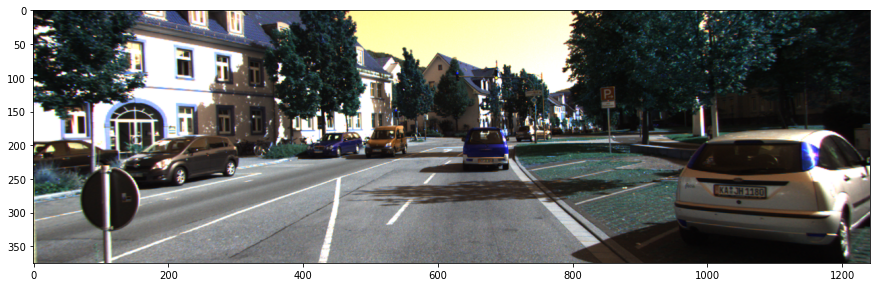

Brightened image


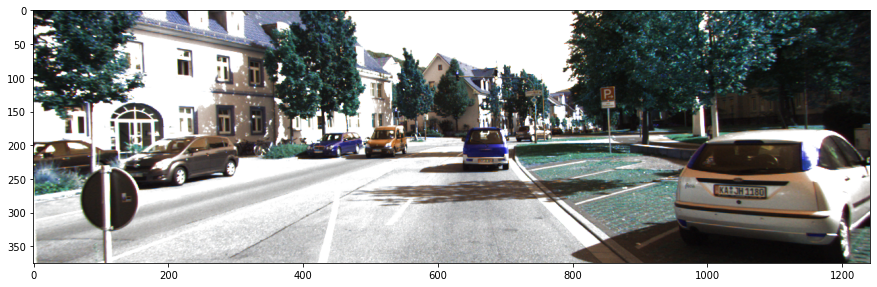

Darkened image


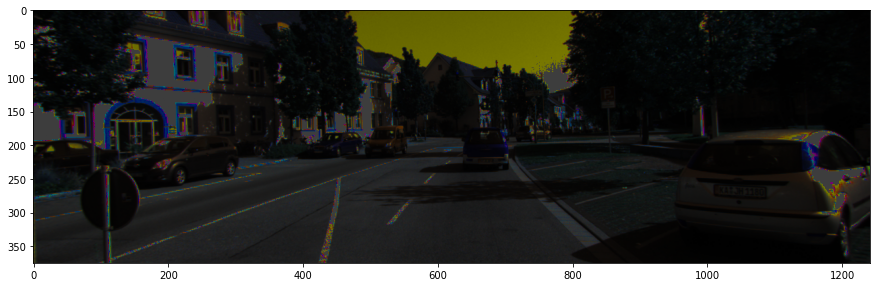

Image with added shadows


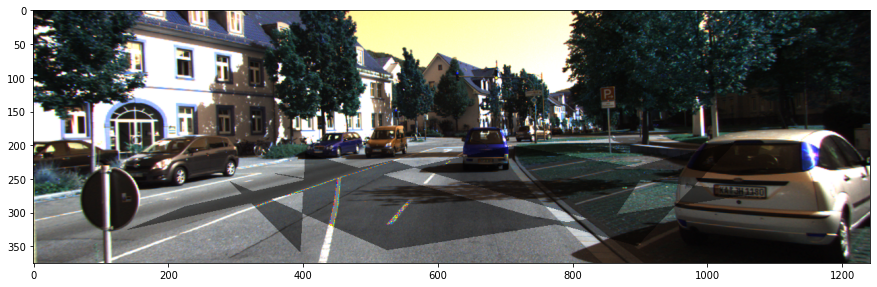

Image with snow


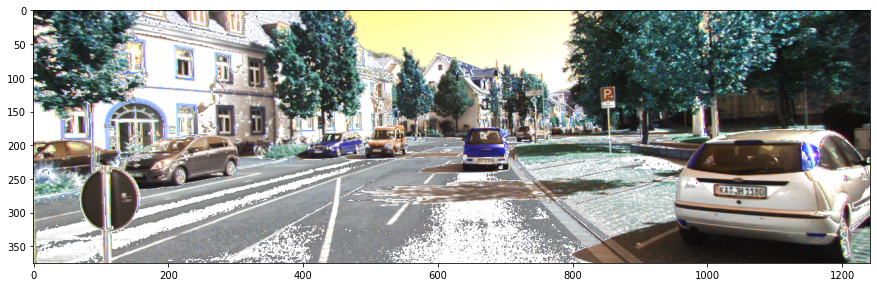

Image with fog


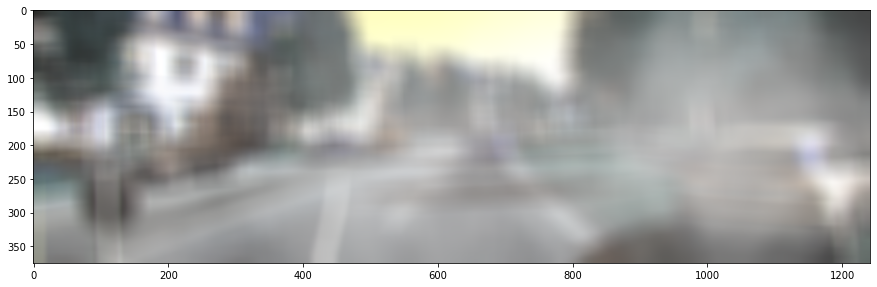

In [11]:
# Displays how Augmentation has been done
# Here it has been done for a particular image. Same is done for all the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

src = "./training_aug/image_2/"
file = "umm_000040"

print("Normal Image")
img = mpimg.imread(src+file+".png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

print("Brightened image")
img = mpimg.imread(src+file+"_1.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

print("Darkened image")
img = mpimg.imread(src+file+"_2.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

print("Image with added shadows")
img = mpimg.imread(src+file+"_3.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

print("Image with snow")
img = mpimg.imread(src+file+"_4.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

print("Image with fog")
img = mpimg.imread(src+file+"_5.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

In [12]:
# Displaying the size of any 1 image
image = cv2.imread('../input/kitti-road-dataset/data_road/training/image_2/um_000029.png')
print(image.shape)

#After this we would normalize the size of the images. This is just to show the size of the image initially

(375, 1242, 3)


# Use of FTSwishPlus activation function 

FTSwishPlus stands for **Fixed Threshold Swish with mean shifting**. It is a fairly new activation function in the field of deep learning, which is gaining immense popularity owing to **drawbacks of ReLu (removal of all negative values and the associated dying gradient)**.

FTSwish provides a threshold (a fixed negative value) for all the negative inputs and a swish like curve for the positive values.
![](https://miro.medium.com/max/1400/1*65GqKY9Wakryky1DPpa8nQ.jpeg)

*Image Source*:https://lessw.medium.com/comparison-of-activation-functions-for-deep-learning-initial-winner-ftswish-f13e2621847


**In Mean Shifting**, The core idea is to adjust the starting point in such a manner that it adjusts the activation function to give Standard Normal distribution values of standard deviation and mean, 1 and 0 repectively.

 In this case, **for FTSwish, it requires an adjustment of -0.1** to get a mean of zero. This adjustment is then applied every time the FTSwish activation is used.

 # Defining the Blueprint Of FTSwishPlus Activation Function

In [13]:

class FTSwishPlus(nn.Module):
    """
        Implementation of Fixed Threshold Swish with mean shifting (FTSwish+) activation function
        References -  
                (i)  https://arxiv.org/pdf/1812.06247.pdf
                (ii) https://medium.com/@lessw/comparison-of-activation-functions-for-deep-learning-initial-winner-ftswish-f13e2621847
    """
    
    def __init__(self, threshold=-0.25, mean_shift=-0.1):
        #Constructor Initialization
        super().__init__()
        
        #Setting the threshold value
        self.threshold = threshold
        
        #Performing mean shift operation
        self.mean_shift = mean_shift
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def forward(self, x):

        #FTSwish+ for positive values
        pos_value = (x * F.sigmoid(x)) + self.threshold

        #FTSwish+ for negative values
        tval = torch.tensor([self.threshold], device=self.device)

        x = torch.where(x >= 0, pos_value, tval)

        if self.mean_shift is not None:
            x.sub_(self.mean_shift)

        return x

#  IMPLEMENTATION OF AUXILARY MODULES

 # * Channel Attention
 
     A Channel Attention Module is a module for channel-based attention in convolutional neural networks. We produce a channel attention map by exploiting the inter-channel relationship of features. As each channel of a feature map is considered as a feature detector, channel attention focuses on ‘what’ is meaningful given an input image. Both average-pooling and max-pooling operations, generating two different spatial context descriptors: Fmax and Favg, which denote average-pooled features and max-pooled features respectively. 
     
# * Spatial Attention

    Paying attention by emphasizing the locations of percepts with high saliency is what is referred to as  spatial attention.a spatial attention map by utilizing the inter-spatial relationship of features. Different from the channel attention, the spatial attention focuses on ‘where’ is an informative part, which is complementary to the channel attention. To compute the spatial attention, we first apply average-pooling and max-pooling operations along the channel axis and concatenate them to generate an efficient feature descriptor. Applying pooling operations along the channel axis is shown to be effective in highlighting informative regions [33]. On the concatenated feature descriptor, we apply a convolution layer to generate a spatial attention map Ms(F) ∈ RH×W which encodes where to emphasize or suppress.
    
![](https://www.researchgate.net/publication/338407902/figure/fig2/AS:844335574683659@1578316696753/The-detailed-structure-of-channel-and-spatial-attention-module-Top-Channel-wise.png)    


     

In [14]:

class ChannelAttention(nn.Module):
    """
    References:
        (i) https://arxiv.org/pdf/1807.06521.pdf - CBAM's Channel attention module
        (ii) https://github.com/luuuyi/CBAM.PyTorch/blob/master/model/resnet_cbam.py
    """
    def __init__(self, in_planes, ratio=16, act_type="relu"):
        super(ChannelAttention, self).__init__()
        self.ratio = ratio
        self.act_type = act_type
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // self.ratio, 1, bias=False)
        self.fc2 = nn.Conv2d(in_planes // self.ratio, in_planes, 1, bias=False)

        if self.act_type == "relu":
            self.act = nn.ReLU(inplace=True)
        elif self.act_type == "celu":
            self.act = nn.CELU(inplace=True)
        elif self.act_type == "fts+":
            self.act = FTSwishPlus()
        else:
            raise ValueError("Unknown value: {}".format(self.act_type))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.act(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.act(self.fc1(self.max_pool(x))))
        out = avg_out + max_out

        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    """
    References - 
        (i) https://arxiv.org/pdf/1807.06521.pdf - The spatial attention module for CBAM
        (ii) https://github.com/luuuyi/CBAM.PyTorch/blob/master/model/resnet_cbam.py
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)

        return self.sigmoid(x)


class ConvBNAct(nn.Module):
    """
        This is the structure for a simple convolution block.
        First is the CONV layer: CONV(ks = 3), where ks stands for kernel size
        This is followed by an optional step of Batch Normalization.
        Finally we perform activation.
    """
    def __init__(self, in_channels, 
                out_channels,
                ks=3,
                stride=1,
                padding=1,
                dilation=1, 
                bn_enable=True, 
                act_enable=True,
                act_type="relu"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ks = ks
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.bn_enable = bn_enable
        self.act_enable = act_enable
        self.act_type = act_type

        assert self.act_type in ["relu", "celu", "fts+"], "Error. Unknown activation function: {}".format(self.act_type)

        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=self.ks, stride=self.stride, padding=self.padding, dilation=self.dilation)
        
        if self.bn_enable:
            self.bn = nn.BatchNorm2d(self.out_channels)
        
        if self.act_enable:
            if self.act_type == "relu":
                self.act = nn.ReLU(inplace=True)
            elif self.act_type == "celu":
                self.act = nn.CELU(inplace=True)
            elif self.act_type == "fts+":
                self.act = FTSwishPlus()
            else:
                raise ValueError("Unknown value: {}".format(self.act_type))

    def forward(self, x):
        x = self.conv(x)
        
        if self.bn_enable:
            x = self.bn(x)

        if self.act_enable:
            x = self.act(x)

        return x


class EncoderBlockM1(nn.Module):
    """
        This is the code for base encoder block.
        First is the CONV layer.
        This is followed by an optional step of Batch Normalization.
        Finally we perform activation.
        
    """
    def __init__(self, in_channels, 
                       out_channels,
                       ks=3,
                       stride=1,
                       padding=1,
                       dilation=1, 
                       bn_enable=False,
                       act_type="relu"):
        super(EncoderBlockM1, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ks = ks
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.bn_enable = bn_enable
        self.act_type = act_type

        self.conv = ConvBNAct(self.in_channels, self.out_channels, 
            ks=self.ks, 
            stride=self.stride, 
            padding=self.padding, 
            dilation=self.dilation, 
            bn_enable=self.bn_enable, 
            act_type=self.act_type)

    def forward(self, x):
        x = self.conv(x)
        return x


class DecoderBlockM1(nn.Module):
    """
        This is the implementation of base decoder block
        First comes the Deconv layer. If the upsample attribute is true, then Upsample is implemented else TransposeConv2D is implemented
        This is followed by an optional step of Batch Normalization.
        Finally we perform activation.
    """
    def __init__(self, in_channels,
                       out_channels,
                       ks=4,
                       stride=2,
                       padding=1, 
                       dilation=1,
                       bn_enable=False,
                       upsample=False,
                       act_enable=True,
                       act_type="relu"):
        super(DecoderBlockM1, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ks = ks
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.bn_enable = bn_enable
        self.upsample = upsample
        self.act_enable = act_enable
        self.act_type = act_type

        assert self.act_type in ["relu", "celu", "fts+"], "Error. Unknown activation function: {}".format(self.act_type)

        self.deconv = nn.Upsample(scale_factor=2, mode='bilinear') if self.upsample else nn.ConvTranspose2d(in_channels=self.in_channels,
                                                                                                           out_channels=self.out_channels,
                                                                                                           kernel_size=self.ks,
                                                                                                           stride=self.stride,
                                                                                                           padding=self.padding,
                                                                                                           dilation=self.dilation)

        if self.upsample:
            self.conv = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1)

        if self.bn_enable:
            self.bn = nn.BatchNorm2d(self.out_channels)

        if self.act_enable:
            if self.act_type == "relu":
                self.act = nn.ReLU(inplace=True)
            elif self.act_type == "celu":
                self.act = nn.CELU(inplace=True)
            elif self.act_type == "fts+":
                self.act = FTSwishPlus()
            else:
                raise ValueError("Unknown value: {}".format(self.act_type))

    def forward(self, x):
        x = self.deconv(x)
        if self.upsample:
            x = self.conv(x)

        if self.bn_enable:
            x = self.bn(x)

        if self.act_enable:
            x = self.act(x)

        return x


class DecoderBlockM2(nn.Module):
    """
        Decoder block with middle channels: 
            1: Upsample -> ConvBNAct -> ConvBNAct
            2: ConvBNAct -> ConvTranspose -> Act
    """
    def __init__(self, in_channels,
                       middle_channels, 
                       out_channels,
                       ks=4,
                       stride=2,
                       padding=1, 
                       dilation=1,
                       upsample=False,
                       act_type="relu"):
        """
            params:
                in_channels         :
                middle_channels     :
                out_channels        :
                ks                  : kernel size
                stride              :
                padding             :
                dilation            :
                upsample            : Uses nn.Upsample if True else nn.ConvTranspose2D
        """
        super(DecoderBlockM2, self).__init__()
        
        self.in_channels = in_channels
        self.mid_channels = middle_channels
        self.out_channels = out_channels
        self.ks = ks
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.upsample = upsample
        self.act_type = act_type

        if self.upsample:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear"),
                ConvBNAct(in_channels=self.in_channels, out_channels=self.mid_channels, act_type=self.act_type),
                ConvBNAct(in_channels=self.mid_channels, out_channels=self.out_channels, act_type=self.act_type)
            )
        else:
            self.block = nn.Sequential(
                ConvBNAct(in_channels=self.in_channels, out_channels=self.mid_channels, act_type=self.act_type),
                nn.ConvTranspose2d(in_channels=self.mid_channels, out_channels=self.out_channels, kernel_size=self.ks, stride=self.stride, padding=self.padding, dilation=self.dilation),
                nn.BatchNorm2d(self.out_channels)
            )

        if not self.upsample:
            if self.act_type == "relu":
                self.act = nn.ReLU(inplace=True)
            elif self.act_type == "celu":
                self.act = nn.CELU(inplace=True)
            elif self.act_type == "fts+":
                self.act = FTSwishPlus()
            else:
                raise ValueError("Unknown value: {}".format(self.act_type))

    def forward(self, x):
        x = self.block(x)

        if not self.upsample:
            x = self.act(x)
        
        return x


class CenterBlockM1(nn.Module):
    """
        Center module. This module consists of sequential convolutions and drop-outs modules.
    """

    def __init__(self, num_channels=32, act_type="relu"):
        super().__init__()
        self.num_channels = num_channels
        self.act_type = act_type

        self.block = nn.Sequential(
            ConvBNAct(self.num_channels, self.num_channels, ks=3, padding=(1,2), dilation=(1,2), act_type=self.act_type), #256
            nn.Dropout2d(p=.25),  
            ConvBNAct(self.num_channels, self.num_channels, ks=3, padding=(1,3), dilation=(1,3), act_type=self.act_type), #256
            nn.Dropout2d(p=.25),
            ConvBNAct(self.num_channels, self.num_channels, ks=3, padding=(1,4), dilation=(1,4), act_type=self.act_type), #256
            nn.Dropout2d(p=.25),
            ConvBNAct(self.num_channels, self.num_channels, ks=3, padding=(1,5), dilation=(1,5), act_type=self.act_type), #256
            nn.Dropout2d(p=.25),
            ConvBNAct(self.num_channels, self.num_channels, ks=1, padding=(0,0), dilation=(1,1), act_type=self.act_type), #256
            nn.Dropout2d(p=.25)
        )

    def forward(self, x):
        x = self.block(x)
        return x


class CenterBlockM2(nn.Module):
    """
        This is the implemetation of CenterBlockM2
    """
    def __init__(self, in_channels=256, settings=(1,2,3,6), pooling_type="max", bn_enable=True, act_type="relu"):
        super().__init__()

        assert len(settings) > 0, "Wrong settings: {}".format(settings)
        assert pooling_type in ["max", "avg"], "Unknown pooling: {}".format(pooling_type)
        assert act_type in ["relu", "celu", "fts+"], "Unknown activation: {}".format(act_type)

        self.in_channels = in_channels
        self.settings = settings
        self.out_channels = self.in_channels // len(self.settings)
        self.pooling_type = pooling_type
        self.bn_enable = bn_enable
        self.act_type = act_type

        self.pyramid = []
        for s in self.settings:
            pyramid_block = []
            if self.pooling_type == "max":
                pyramid_block.append(nn.AdaptiveMaxPool2d(s))
            else:
                pyramid_block.append(nn.AdaptiveAvgPool2d(s))
            
            pyramid_block.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1))

            if self.bn_enable:
                pyramid_block.append(nn.BatchNorm2d(num_features=self.out_channels))
            
            if self.act_type == "relu":
                pyramid_block.append(nn.ReLU(inplace=True))
            elif self.act_type == "celu":
                pyramid_block.append(nn.CELU(inplace=True))
            else:
                pyramid_block.append(FTSwishPlus())
            self.pyramid.append(nn.Sequential(*pyramid_block))
        
        self.pyramid = nn.ModuleList(self.pyramid)


    def forward(self, x):
        h = x.shape[2]
        w = x.shape[3]
        
        result = [x]
        for p in self.pyramid:
            res_x = p(x)
            res_x = F.upsample(res_x, size=(h,w), mode="bilinear")
            result.append(res_x)
        
        return torch.cat(result, dim=1)


class CenterBlockM3(nn.Module):
    """
        This is the implementation for Center block M3
    """
    def __init__(self, in_channels=256, settings=[(3,1,1),(3,2,2)], fusion_type="cat", act_type="relu", attention=False, use_skip=True):
        """
            Params:
                in_channels     : input channels
                settings        : (kernel_size, dilation_h, dilation_w)   
                fustion_type    : type of fustion. Can be "cat" or "sum"
                act_type        : activation type
                attention       : CBAM attention enabling
                use_skip        : if True then source tensor will be reductioned with others, else not.
        """
        super().__init__()

        assert len(settings) % 2 == 0, "Wrong number of levels in pyramid: {}".format(len(settings))

        self.act_type = act_type
        self.settings = settings
        self.fusion_type = fusion_type
        self.attention = attention
        self.use_skip = use_skip
        self.in_channels = in_channels
        self.out_channels = self.in_channels // len(self.settings) 

        if self.attention:
            self.ca = ChannelAttention(self.out_channels, act_type=self.act_type)
            self.sa = SpatialAttention(kernel_size=3)

        self.pyramid = []
        for s in self.settings:
            ks, d_h, d_w = s
            self.pyramid.append(ConvBNAct(in_channels=self.in_channels, 
                    out_channels=self.out_channels,
                    ks=ks,
                    padding=((ks//2) * d_h, (ks//2) * d_w),
                    dilation=(d_h, d_w),
                    act_type=self.act_type 
                )
            )
        self.pyramid = nn.ModuleList(self.pyramid)

    def forward(self, x):
        if self.fusion_type == "cat":
            result = [x] if self.use_skip else []
            for p in self.pyramid:
                res_x = p(x)
                
                if self.attention:
                    res_x = self.ca(res_x) * res_x
                    res_x = self.sa(res_x) * res_x

                result.append(res_x) 
            return torch.cat(result, dim=1)         #concatination of features
        elif self.fusion_type == "sum":
            result = []
            for p in self.pyramid:
                res_x = p(x)

                if self.attention:
                    res_x = self.ca(res_x) * res_x
                    res_x = self.sa(res_x) * res_x

                result.append(res_x)
            result = torch.cat(result, dim=1)      
            return x + result                       #sum of features
        else:
            raise RuntimeError("Unknown fusion type: {}".format(self.fusion_type))

# IMPLEMENTATION OF THE RESNET FRAMEWORK

This framework consists of five encoder blocks which is followed by a central block formed by convolving the last encoder layer with a convolutional layer of 256 kernels of size 3 x 3. This is followed by a decoder block for which we have used the Conv2DTranspose operation (as an experiment) instead of the Up-sampling operation implemented in the paper.

In [15]:
class ResNetM2(nn.Module):
    def __init__(self, num_classes=2,
            ebn_enable=True, 
            dbn_enable=True, 
            upsample_enable=False,
            attention=True,
            use_skip=True,
            act_type="relu", 
            init_type="He"):
        """
            params:
                num_classes     : 
                ebn_enable      : encoder batch norm
                dbn_enable      : decoder batch norm
                upsample_enable : nn.Upsample used if this parameter is True, else nn.ConvTranspose2D used.
                attention       : CBAM attention
                use_skip        : skip-connection in Context Module
                act_type        : type of activation. Can be Relu, Celu or FTSwish+
                init_type       : type of initialization: He or Xavier
        """
        super(ResNetM2, self).__init__()
        self.num_classes = num_classes
        self.ebn_enable = ebn_enable
        self.dbn_enable = dbn_enable
        self.upsample_enable = upsample_enable
        self.attention = attention
        self.use_skip = use_skip
        self.act_type = act_type
        self.init_type = init_type

        if self.init_type not in ["He", "Xavier"]:
            raise ValueError("Unknown initialization type: {}".format(self.init_type))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block1 = nn.Sequential(
            EncoderBlockM1(3, 32, bn_enable=self.ebn_enable, act_type=self.act_type),
            EncoderBlockM1(32, 32, bn_enable=self.ebn_enable, act_type=self.act_type)                                   
        )
        
        self.encoder_block2 = nn.Sequential(
            EncoderBlockM1(32, 64, bn_enable=self.ebn_enable, act_type=self.act_type),
            EncoderBlockM1(64, 64, bn_enable=self.ebn_enable, act_type=self.act_type)                                
        )

        self.encoder_block3 = nn.Sequential(
            EncoderBlockM1(64, 128, bn_enable=self.ebn_enable, act_type=self.act_type),
            EncoderBlockM1(128, 128, bn_enable=self.ebn_enable, act_type=self.act_type)                                
        )
        
        self.encoder_block4 = nn.Sequential(
            EncoderBlockM1(128, 128, bn_enable=self.ebn_enable, act_type=self.act_type),
            EncoderBlockM1(128, 128, bn_enable=self.ebn_enable, act_type=self.act_type)        
        )
        
        self.encoder_block5 = nn.Sequential(
            EncoderBlockM1(128, 256, bn_enable=self.ebn_enable, act_type=self.act_type),
            EncoderBlockM1(256, 256, bn_enable=self.ebn_enable, act_type=self.act_type)     
        )
        
        # self.center = CenterBlock(num_channels=256, act_type=self.act_type)                                                    

        self.center = nn.Sequential(
            CenterBlockM3(in_channels=256, settings=[(3,1,2),(3,1,3),(3,1,4),(3,1,5)], attention=self.attention, use_skip=self.use_skip, act_type=self.act_type),
            nn.Dropout2d(p=.25)
        )

        self.decoder_block5 = nn.Sequential(
            DecoderBlockM1(256 + (512 if self.use_skip else 256), 128, bn_enable=self.dbn_enable, upsample=self.upsample_enable, act_type=self.act_type),
            ConvBNAct(128, 128, act_type=self.act_type)
        )
        self.decoder_block4 = nn.Sequential(
            DecoderBlockM1(128 + 128, 128, bn_enable=self.dbn_enable, upsample=self.upsample_enable, act_type=self.act_type),
            ConvBNAct(128, 128, act_type=self.act_type)
        )
        self.decoder_block3 = nn.Sequential(
            DecoderBlockM1(128 + 128, 64, bn_enable=self.dbn_enable, upsample=self.upsample_enable, act_type=self.act_type),
            ConvBNAct(64, 64, act_type=self.act_type)
        )
        self.decoder_block2 = nn.Sequential(
            DecoderBlockM1(64 + 64, 32, bn_enable=self.dbn_enable, upsample=self.upsample_enable, act_type=self.act_type),
            ConvBNAct(32, 32, act_type=self.act_type)
        )
        self.decoder_block1 = nn.Sequential(
            DecoderBlockM1(32 + 32, 16, bn_enable=self.dbn_enable, upsample=self.upsample_enable, act_type=self.act_type),
            ConvBNAct(16, 16, act_type=self.act_type)
        )
        self.final = nn.Conv2d(16, self.num_classes, kernel_size=3, padding=1)

        #Initialization
        if self.init_type == "He":
            for m in self.modules():
                if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        m.bias.data.zero_() 
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
        elif self.init_type == "Xavier":
            raise NotImplementedError("This type of initialization is not implemented.")


    def forward(self, x):
        conv1 = self.encoder_block1(x)
        pool1 = self.pool(conv1)
        conv2 = self.encoder_block2(pool1)
        pool2 = self.pool(conv2)
        conv3 = self.encoder_block3(pool2)
        pool3 = self.pool(conv3)
        conv4 = self.encoder_block4(pool3)
        pool4 = self.pool(conv4)
        conv5 = self.encoder_block5(pool4)
        pool5 = self.pool(conv5)

        cent = self.center(pool5)

        dec5 = self.decoder_block5(torch.cat([cent, pool5], dim=1))
        dec4 = self.decoder_block4(torch.cat([dec5, pool4], dim=1))
        dec3 = self.decoder_block3(torch.cat([dec4, pool3], dim=1))
        dec2 = self.decoder_block2(torch.cat([dec3, pool2], dim=1))
        dec1 = self.decoder_block1(torch.cat([dec2, pool1], dim=1))

        x_out = self.final(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(x_out, dim=1)

        return x_out

# TRAINING THE MODEL

In [16]:
import torch
import cv2
from glob import glob
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import argparse
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

np.random.seed(1234)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(n_epoch, trainloader):
    
    
    model2 = ResNetM2(num_classes=args['num_classes'])
    model2.to(device)
    optimizer = torch.optim.Adam(model2.parameters(), lr=args['lr'])
    criterion = nn.BCELoss()
    e = []
    running_loss_plot = []

    for epoch in range(n_epoch):
        
        running_loss = 0.0
        running_loss_copy=0.0
        
        for i, data in enumerate(trainloader):
            sample = data
            images = sample['image']
            images = images.float()
            labels = sample['label']
            labels = labels.float()
            images = Variable(images.cuda())
            labels = Variable(labels.cuda(), requires_grad=False)

            optimizer.zero_grad()
            output = model2(images)
            output = torch.sigmoid(output)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #running_loss_plot.append(float(running_loss/10))
            running_loss_copy = (running_loss)
            if i % 10 == 9:    # print every 10 mini-batches
                print('Epoch: %d, Loss: %.4f' %
                      (epoch + 1, running_loss / 10))
                #plt.hold(on)
                running_loss = 0.0
                
        e.append(epoch)
        running_loss_plot.append(running_loss_copy)
        
    plt.plot(e, running_loss_plot)
    print(len(e))
    print(len(running_loss_plot))
    plt.xlabel("No. of epochs")
    plt.ylabel("BCE Loss")
    plt.show()
    return model2


    

# MAIN FUNCTION (INCLUDING TESTING ON UNSEEN IMAGES)

In [17]:
def main():
    kitti_train = KittiDatasetTrain(rootdir=args['root_dir'] )
    kitti_test = KittiDatasetTest(rootdir=args['root_dir'])

    trainloader = DataLoader(kitti_train, batch_size=args['batch_size'])
    testloader = DataLoader(kitti_test, batch_size=1)

    print("Training model..")
    model2 = train(args['epochs'], trainloader)
    print("Completed training!")
    print("Starting inference...")
    test_folder = os.path.join(args['root_dir'], "testing/image_2")
    if not os.path.exists(args['output_dir']):
        os.makedirs(args['output_dir'])
    save_inference_samples(args['output_dir'], testloader,
                            model2, test_folder)
    print("Inference completed!")

Training model..
Epoch: 1, Loss: 0.6437
Epoch: 2, Loss: 0.4888
Epoch: 3, Loss: 0.4458
Epoch: 4, Loss: 0.4210
Epoch: 5, Loss: 0.4115
Epoch: 6, Loss: 0.4015
Epoch: 7, Loss: 0.3965
Epoch: 8, Loss: 0.3918
Epoch: 9, Loss: 0.3901
Epoch: 10, Loss: 0.3865
Epoch: 11, Loss: 0.3850
Epoch: 12, Loss: 0.3873
Epoch: 13, Loss: 0.3830
Epoch: 14, Loss: 0.3796
Epoch: 15, Loss: 0.3768
Epoch: 16, Loss: 0.3755
Epoch: 17, Loss: 0.3756
Epoch: 18, Loss: 0.3765
Epoch: 19, Loss: 0.3761
Epoch: 20, Loss: 0.3747
Epoch: 21, Loss: 0.3710
Epoch: 22, Loss: 0.3689
Epoch: 23, Loss: 0.3677
Epoch: 24, Loss: 0.3661
Epoch: 25, Loss: 0.3654
Epoch: 26, Loss: 0.3662
Epoch: 27, Loss: 0.3678
Epoch: 28, Loss: 0.3677
Epoch: 29, Loss: 0.3664
Epoch: 30, Loss: 0.3658
Epoch: 31, Loss: 0.3648
Epoch: 32, Loss: 0.3634
Epoch: 33, Loss: 0.3620
Epoch: 34, Loss: 0.3605
Epoch: 35, Loss: 0.3602
Epoch: 36, Loss: 0.3602
Epoch: 37, Loss: 0.3594
Epoch: 38, Loss: 0.3598
Epoch: 39, Loss: 0.3592
Epoch: 40, Loss: 0.3598
Epoch: 41, Loss: 0.3600
Epoch: 4

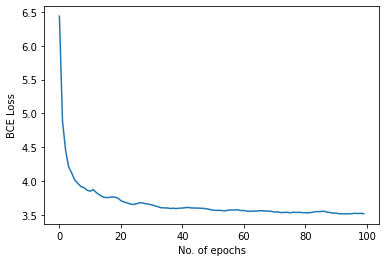

Completed training!
Starting inference...
Training Finished. Saving test images to: ./output
Inference completed!


In [18]:
main()

# Displaying output on unseen test images

Some test images showing the output


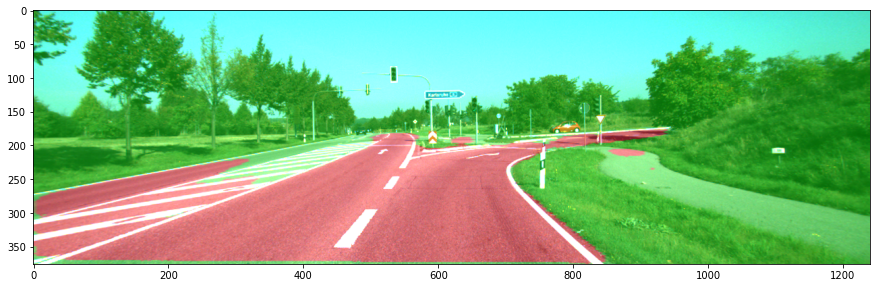

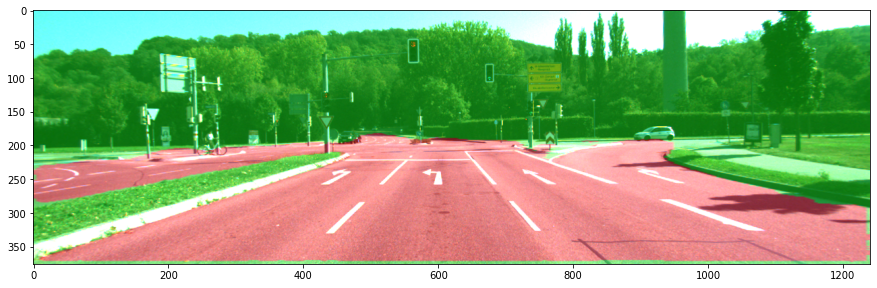

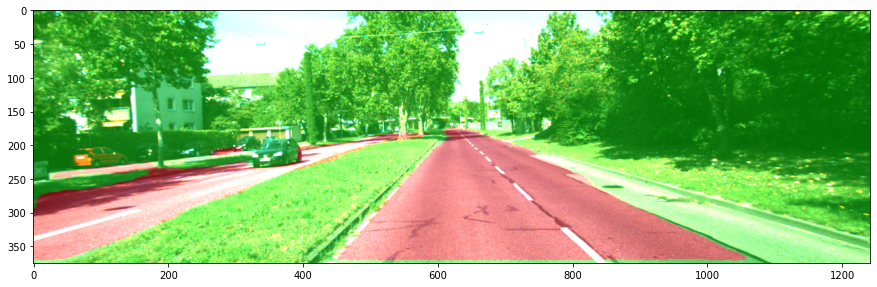

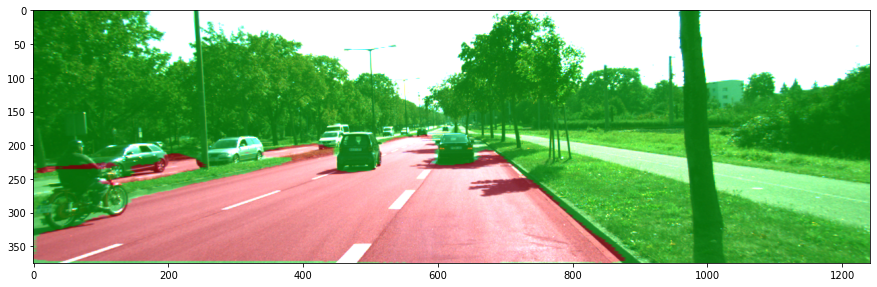

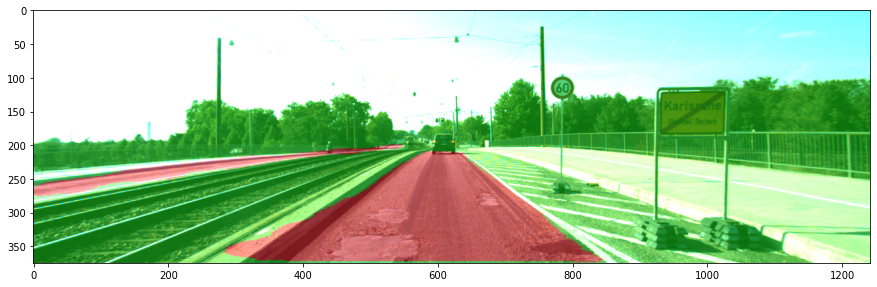

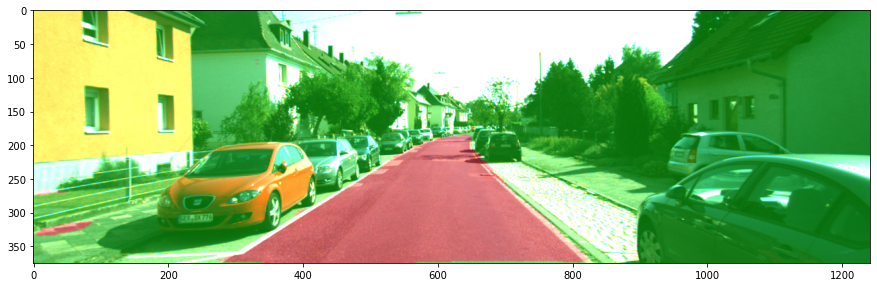

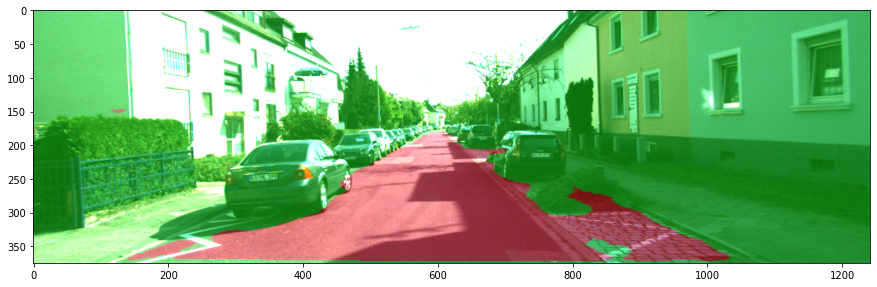

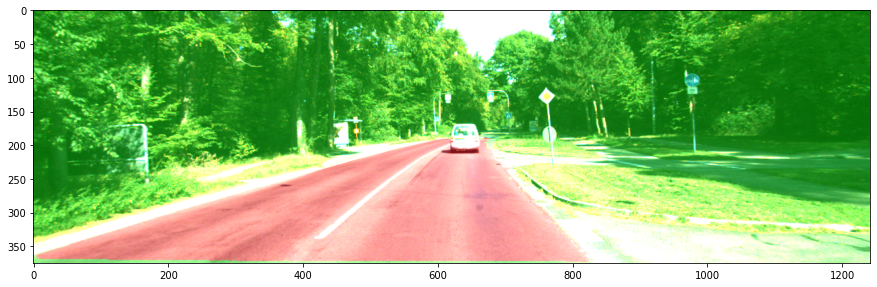

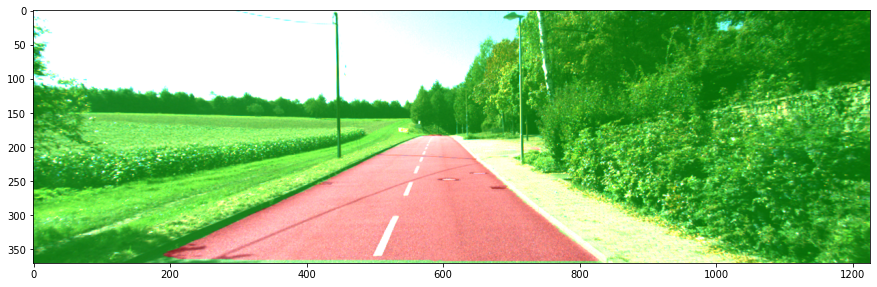

In [19]:
print("Some test images showing the output")
file = './output/'

img = mpimg.imread(file+"umm_000093.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"umm_000089.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"umm_000010.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"umm_000024.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"uu_000079.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"uu_000026.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"uu_000022.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"um_000006.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread(file+"um_000081.png")
plt.figure(figsize = (15,10))
imgplot = plt.imshow(img)
plt.show()

# Conclusion and Future works

We have successfully implemented our own framework based on a structure guided lane detection framework SG-Net. Although our framework is a bit different in that ours is more of an attention guided framework as compared to the structure guided framework proposed in the paper. It should be noted that the feature extractor used by us is similar to the one used in the paper and hence it can be concluded that the backbone of our framework is based on the SG-Net framework although the lane representations and the procedure to learn them are a bit different.

Keeping an eye on the future prospects of this project, we can look to implement a solution to further dissect multiple lanes (as was done in the original SG-Net paper). This is currently a limitation of our project; it fails to distinguish multiple lines. This is something that we would like to work on in the future.